In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    training_dir = "./gdrive/My Drive/fingerprint/train/"
    testing_dir = "./gdrive/My Drive/fingerprint/test/"
    train_batch_size = 64
    train_number_epochs = 100

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls "./gdrive/My Drive/fingerprint/train"

1   11	14  16	18  2	21  23	25  28	3   31	33  35	38  4  6  8
10  13	15  17	19  20	22  24	26  29	30  32	34  37	39  5  7  9


In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [0]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

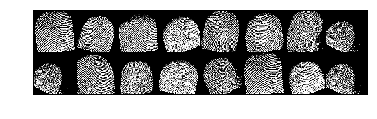

[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [8]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 700),
            nn.ReLU(inplace=True),

            nn.Linear(700, 700),
            nn.ReLU(inplace=True),

            nn.Linear(700, 5),
            nn.Sigmoid())

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

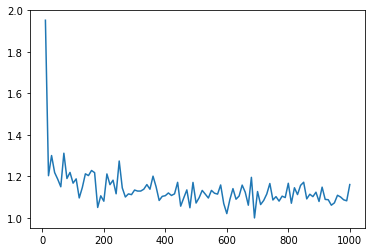

In [14]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        print(img0)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [15]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
img0_tuple = folder_dataset.imgs[0]
print(img0_tuple[1])
img1_tuple = folder_dataset.imgs[1]
print(img1_tuple[1])
dataiter = iter(test_dataloader)
labels_test = []
similarity_score = []
for i in range(50):
  try:
    x0,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    labels_test.append(label2.item())
    similarity_score.append(1-euclidean_distance.item())
  except:
    break;
print(labels_test)
print(similarity_score)
len(labels_test)


0
0
[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[0.8552175611257553, 0.7153837978839874, 0.8627045750617981, 0.7070270478725433, 0.7672018706798553, 0.7627431452274323, 0.8011668175458908, 0.6189332008361816, 0.895351342856884, 0.6964552998542786, 0.7429604232311249, 0.7307212054729462, 0.683216780424118, 0.8389700502157211, 0.8771450370550156, 0.999997763932015, 0.8008210062980652, 0.8957477435469627, 0.6884945333003998, 0.6523477733135223, 0.820517361164093, 0.7891663461923599, 0.880140446126461, 0.8957508131861687, 0.8100787252187729, 0.7536779493093491, 0.8619274795055389, 0.6958804130554199, 0.8983398005366325, 0.9005811437964439, 0.9475741311907768, 0.8231137096881866, 0.7807224690914154]


33

[(0.999997763932015, 0.0), (0.9475741311907768, 1.0), (0.9005811437964439, 0.0), (0.8983398005366325, 0.0), (0.8957508131861687, 0.0), (0.8957477435469627, 0.0), (0.895351342856884, 0.0), (0.880140446126461, 0.0), (0.8771450370550156, 0.0), (0.8627045750617981, 1.0), (0.8619274795055389, 1.0), (0.8552175611257553, 0.0), (0.8389700502157211, 0.0), (0.8231137096881866, 0.0), (0.820517361164093, 0.0), (0.8100787252187729, 1.0), (0.8011668175458908, 1.0), (0.8008210062980652, 0.0), (0.7891663461923599, 0.0), (0.7807224690914154, 0.0), (0.7672018706798553, 1.0), (0.7627431452274323, 1.0), (0.7536779493093491, 1.0), (0.7429604232311249, 1.0), (0.7307212054729462, 1.0), (0.7153837978839874, 1.0), (0.7070270478725433, 0.0), (0.6964552998542786, 1.0), (0.6958804130554199, 0.0), (0.6884945333003998, 0.0), (0.683216780424118, 1.0), (0.6523477733135223, 1.0), (0.6189332008361816, 1.0)]


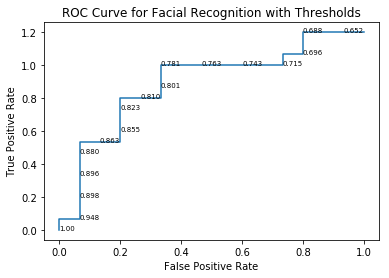

In [16]:
tuples =zip(similarity_score, labels_test)
avg0 = 0
avg1 = 0
num = 0
tuples_list = sorted(tuples)
for t in sorted(tuples):
  #print(t)
  if(t[0]==0.0):
    avg0 +=t[1]
    num+=1
  else:
    avg1 +=t[1]
tuples_list.reverse()
datapoint = []
true_ = 0
false_ = 0
for t in tuples_list:
  if(t[1]==0.0):
    true_+=1
    datapoint.append((false_,true_))
  else:
    false_+=1
    datapoint.append((false_,true_))
import matplotlib.pyplot as plt
x = [0]
y = [0]
i=0
baseX = []
baseY = []
for i in range(0,16):
  baseX.append(i/15.0)
  baseY.append(i/15.0)
for pts in datapoint:
  x.append(pts[0]/15.0)
  y.append(pts[1]/15.0)
plt.plot(x,y)
#plt.plot(baseX,baseY,'y--')
plt.title("ROC Curve for Facial Recognition with Thresholds")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
i = 1
print(tuples_list)
plt.text(x[0], y[0], str(f'{1.00:.2f}'), color="black", fontsize=7)
for z in tuples_list:
  if(i%2==0):
    plt.text(x[i], y[i], str(f'{z[0]:.3f}'), color="black", fontsize=7)
  i+=1
plt.show()